In [1]:
import utils
import classes
import h5py
import pandas as pd
from keras.layers import *
from keras import Model
from keras.models import Sequential
from keras.layers.advanced_activations import PReLU
from keras import regularizers
import numpy as np
import keras, time
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
features = np.load('DGCNN.npy')
labels = np.load('labels.npy')

In [3]:
features.shape

(98769, 30, 7)

In [4]:
labels.shape

(98769, 5)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [6]:
model= classes.EdgeConvClassifier((30, 7)).model

In [7]:
model.compile(
            optimizer=keras.optimizers.Adam(lr=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['acc'])

In [8]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 7)        0                                            
__________________________________________________________________________________________________
edge_conv_1 (EdgeConv)          (None, 30, 64)       10048       input_1[0][0]                    
__________________________________________________________________________________________________
edge_conv_2 (EdgeConv)          (None, 30, 64)       17344       edge_conv_1[0][0]                
__________________________________________________________________________________________________
edge_conv_3 (EdgeConv)          (None, 30, 128)      51072       edge_conv_2[0][0]                
____________________________________________________________________________________________

In [9]:
history = model.fit(X_train, y_train,
        verbose=2,
        batch_size=1024,
        validation_split=0.2,
        epochs=50)

Train on 63212 samples, validate on 15803 samples
Epoch 1/50
 - 77s - loss: 1.3998 - acc: 0.4016 - val_loss: 1.2088 - val_acc: 0.5043
Epoch 2/50
 - 68s - loss: 1.0811 - acc: 0.5738 - val_loss: 1.0371 - val_acc: 0.5629
Epoch 3/50
 - 64s - loss: 0.9193 - acc: 0.6533 - val_loss: 0.9226 - val_acc: 0.6434
Epoch 4/50
 - 65s - loss: 0.8493 - acc: 0.6925 - val_loss: 0.8314 - val_acc: 0.7068
Epoch 5/50
 - 67s - loss: 0.8066 - acc: 0.7116 - val_loss: 0.7709 - val_acc: 0.7269
Epoch 6/50
 - 65s - loss: 0.7653 - acc: 0.7322 - val_loss: 0.7387 - val_acc: 0.7348
Epoch 7/50
 - 64s - loss: 0.7329 - acc: 0.7458 - val_loss: 0.7077 - val_acc: 0.7534
Epoch 8/50
 - 66s - loss: 0.7155 - acc: 0.7516 - val_loss: 0.6993 - val_acc: 0.7511
Epoch 9/50
 - 65s - loss: 0.7016 - acc: 0.7564 - val_loss: 0.6709 - val_acc: 0.7673
Epoch 10/50
 - 65s - loss: 0.6980 - acc: 0.7575 - val_loss: 0.7190 - val_acc: 0.7411
Epoch 11/50
 - 64s - loss: 0.6830 - acc: 0.7644 - val_loss: 0.6743 - val_acc: 0.7626
Epoch 12/50
 - 64s - los

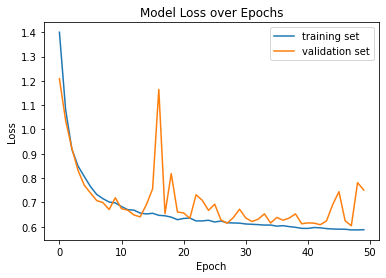

In [10]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training set','validation set'])
plt.show()

In [15]:
label = ['j_g','j_q','j_w','j_z','j_t']

def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'DGCNN ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

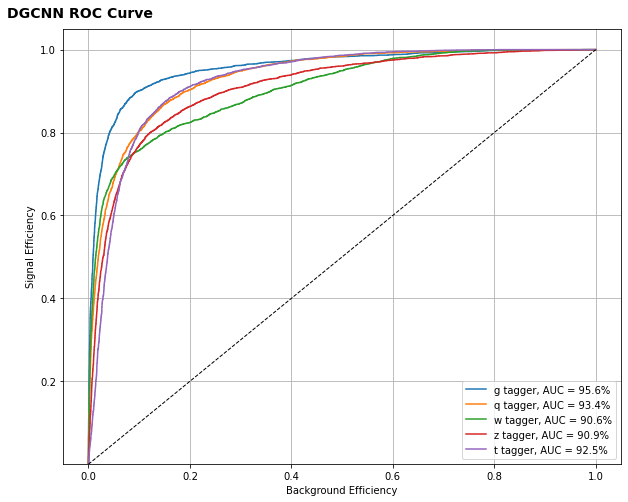

In [16]:
y_pred = makeRoc(X_test, y_test, label, model, outputSuffix='DGCNN')